In [179]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skewnorm
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,r2_score

%matplotlib inline

# Data Description

In [180]:
pop_dataset=pd.read_csv('WorldPopulation.csv')
pop_dataset.index=range(1,71)
pop_dataset.head()

,Year,Population,ChangePerc,NetChange,Density,Urban,UrbanPerc
1,2020,7794798739,1.05,81330639,52,4378993944,56
2,2019,7713468100,1.08,82377060,52,4299438618,56
3,2018,7631091040,1.10,83232115,51,4219817318,55
4,2017,7547858925,1.12,83836876,51,4140188594,55
5,2016,7464022049,1.14,84224910,50,4060652683,54


In [181]:
pop_dataset.shape

(70, 7)

In [182]:
pop_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 1 to 70
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        70 non-null     int64  
 1   Population  70 non-null     int64  
 2   ChangePerc  70 non-null     float64
 3   NetChange   70 non-null     int64  
 4   Density     70 non-null     int64  
 5   Urban       70 non-null     int64  
 6   UrbanPerc   70 non-null     int64  
dtypes: float64(1), int64(6)
memory usage: 4.0 KB


In [183]:
pop_dataset.describe()

,Year,Population,ChangePerc,NetChange,Density,Urban,UrbanPerc
count,70.000000,7.000000e+01,70.000000,7.000000e+01,70.000000,7.000000e+01,70.000000
mean,1985.500000,5.002010e+09,1.616429,7.511954e+07,33.557143,2.226815e+09,42.200000
std,20.351085,1.594877e+09,0.321288,1.256972e+07,10.723989,1.070191e+09,7.447595
min,1951.000000,2.584034e+09,1.050000,4.674740e+07,17.000000,7.750677e+08,30.000000
25%,1968.250000,3.570120e+09,1.262500,7.314225e+07,24.000000,1.294408e+09,36.000000
50%,1985.500000,4.915745e+09,1.770000,7.942852e+07,33.000000,2.035272e+09,41.500000
75%,2002.750000,6.361332e+09,1.847500,8.356683e+07,42.750000,3.054260e+09,48.000000
max,2020.000000,7.794799e+09,2.090000,9.290386e+07,52.000000,4.378994e+09,56.000000


In [184]:
print(pop_dataset.isnull().sum())

Year          0
Population    0
ChangePerc    0
NetChange     0
Density       0
Urban         0
UrbanPerc     0
dtype: int64


No data missing in the given dataset.

# Data Visualization

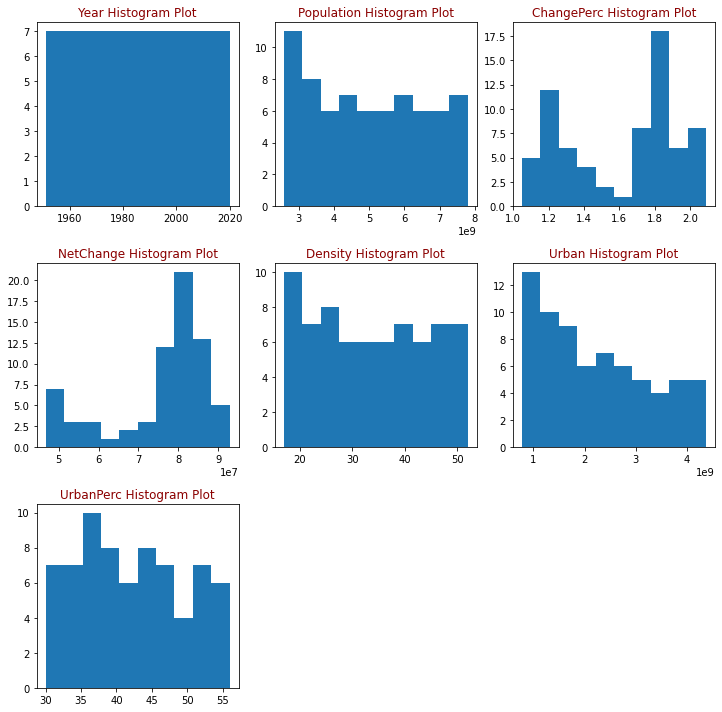

In [185]:
RP=plt.figure(figsize=(10,10))
for i, feature in enumerate(pop_dataset.columns):
    r=RP.add_subplot(3,3,i+1)
    plt.hist(pop_dataset[feature])
    r.set_title(feature+" Histogram Plot",color='DarkRed')
RP.tight_layout()  

In [ ]:
RP=plt.figure(figsize=(10,10))
for i, feature in enumerate(pop_dataset.columns):
    r=RP.add_subplot(3,3,i+1)
    sns.distplot(pop_dataset[feature],rug=True,bins=10,fit=norm,kde=False) #for normalising, used skewnorm
    r.set_title(feature+" Distribution",color='DarkRed')
    if(feature=='Population' or feature=='Urban'):
        plt.yscale('log')
RP.tight_layout()  

#### Right skewed distribution:
Population Distribution, Density Distribution, Urban Distribution
#### Left skewed distribution:
Change Percent Distribution, Net Change Distribution
#### Approximately normal distribution:
Urban Percentage Distribution
#### Normal distribution:
Year Distribution 

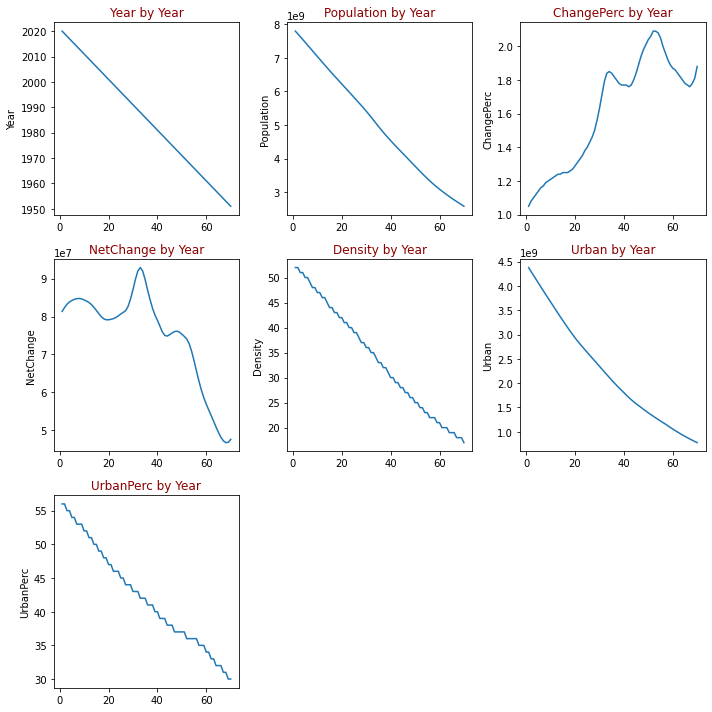

In [188]:
RP=plt.figure(figsize=(10,10))
for i, feature in enumerate(pop_dataset.columns):
    r=RP.add_subplot(3,3,i+1)
    sns.lineplot(pop_dataset.index,pop_dataset[feature])
    r.set_title(feature+" by Year",color='DarkRed')
RP.tight_layout()  

In [189]:
pop_correl=pop_dataset.corr()
print(pop_correl)

                Year  Population  ChangePerc  NetChange   Density     Urban  \
Year        1.000000    0.998403   -0.887211   0.797789  0.997915  0.987119   
Population  0.998403    1.000000   -0.907773   0.768659  0.999640  0.993085   
ChangePerc -0.887211   -0.907773    1.000000  -0.451671 -0.908100 -0.924174   
NetChange   0.797789    0.768659   -0.451671   1.000000  0.767797  0.706693   
Density     0.997915    0.999640   -0.908100   0.767797  1.000000  0.992816   
Urban       0.987119    0.993085   -0.924174   0.706693  0.992816  1.000000   
UrbanPerc   0.994349    0.995669   -0.899791   0.753161  0.995339  0.995454   

            UrbanPerc  
Year         0.994349  
Population   0.995669  
ChangePerc  -0.899791  
NetChange    0.753161  
Density      0.995339  
Urban        0.995454  
UrbanPerc    1.000000  


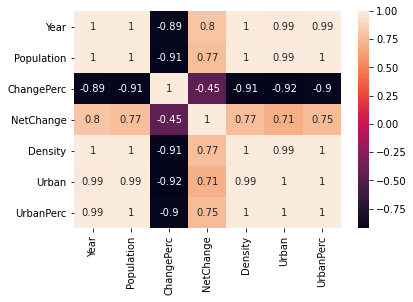

In [190]:
sns.heatmap(pop_correl,annot=True)

In [ ]:
plt.figure(figsize=(5,200))
sns.heatmap(pop_dataset,annot=True,square=True)

# Models

In [194]:
X_data=pop_dataset.drop(['Population','Urban','NetChange'],axis=1)
X=pd.DataFrame(scale(X_data))
X.columns=X_data.columns
Y=pop_dataset['Population']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)

Feature scaling is the process of normalising the range of features in a dataset. Real-world datasets often contain features that are varying in degrees of magnitude, range and units. Therefore, in order for machine learning models to interpret these features on the same scale, we need to perform feature scaling.

### Linear Regression

In [195]:
model_LR=LinearRegression()
model_LR.fit(X_train,Y_train)
Y_pred_LR=model_LR.predict(X_test)

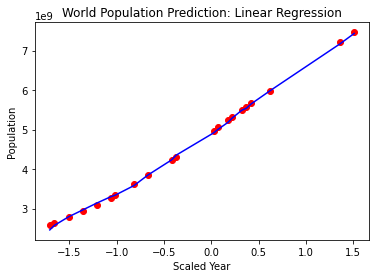

In [196]:
plt.scatter(X_test['Year'], Y_test, color = 'red')
sns.lineplot(X_test['Year'],Y_pred_LR, color = 'blue')
plt.title('World Population Prediction: Linear Regression')
plt.xlabel('Scaled Year')
plt.ylabel('Population')
plt.show()

In [197]:
print('Mean Absolute Error:',mean_absolute_error(Y_test,Y_pred_LR))
print('Linear Regression Coefficients:',model_LR.coef_)
print('R2 Score:',r2_score(Y_test,Y_pred_LR))
print('Mean Squared Error:',mean_squared_error(Y_test,Y_pred_LR))
print('Final Score:',(r2_score(Y_test,Y_pred_LR)*100)/(mean_squared_error(Y_test,Y_pred_LR)+mean_absolute_error(Y_test,Y_pred_LR)))

Mean Absolute Error: 33803393.75958949
Linear Regression Coefficients: [ 7.43664055e+08 -8.79794405e+07  6.38572500e+08  1.23033214e+08]
R2 Score: 0.9990599862236123
Mean Squared Error: 1896014273658965.2
Final Score: 5.2692639622575544e-14


### Logistic Regression

In [198]:
model_LGR=LogisticRegression()
model_LGR.fit(X_train,Y_train)
Y_pred_LGR=model_LGR.predict(X_test)

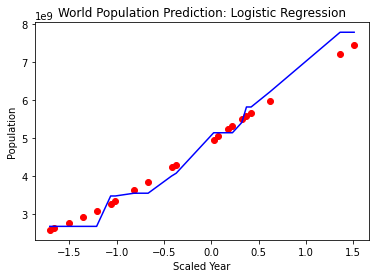

In [199]:
plt.scatter(X_test['Year'], Y_test, color = 'red')
sns.lineplot(X_test['Year'],Y_pred_LGR, color = 'blue')
plt.title('World Population Prediction: Logistic Regression')
plt.xlabel('Scaled Year')
plt.ylabel('Population')
plt.show()

In [ ]:
print('Mean Absolute Error:',mean_absolute_error(Y_test,Y_pred_LGR))
print('Linear Regression Coefficients:\n',model_LGR.coef_)
print('R2 Score:',r2_score(Y_test,Y_pred_LGR))
print('Mean Squared Error:',mean_squared_error(Y_test,Y_pred_LGR))
print('Final Score:',(r2_score(Y_test,Y_pred_LGR)*100)/(mean_squared_error(Y_test,Y_pred_LGR)+mean_absolute_error(Y_test,Y_pred_LGR)))

### XGBoost Regressor

In [204]:
model_XGB = XGBRegressor(n_estimators=500, learning_rate=0.05)
model_XGB.fit(X_train, Y_train, early_stopping_rounds=5, eval_set=[(X_test, Y_test)], verbose=False)
Y_pred_XGB=model_XGB.predict(X_test)

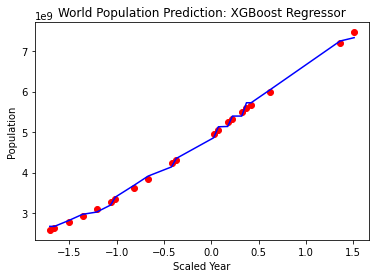

In [205]:
plt.scatter(X_test['Year'], Y_test, color = 'red')
sns.lineplot(X_test['Year'],Y_pred_XGB, color = 'blue')
plt.title('World Population Prediction: XGBoost Regressor')
plt.xlabel('Scaled Year')
plt.ylabel('Population')
plt.show()

In [206]:
print('Mean Absolute Error:',mean_absolute_error(Y_test,Y_pred_XGB))
print('R2 Score:',r2_score(Y_test,Y_pred_XGB))
print('Mean Squared Error:',mean_squared_error(Y_test,Y_pred_XGB))
print('Final Score:',(r2_score(Y_test,Y_pred_XGB)*100)/(mean_squared_error(Y_test,Y_pred_XGB)+mean_absolute_error(Y_test,Y_pred_XGB)))

Mean Absolute Error: 73621005.14285715
R2 Score: 0.9968942494250208
Mean Squared Error: 6264320341360499.0
Final Score: 1.591384513220121e-14


### Random Forest Regressor

In [207]:
model_RFR = RandomForestRegressor(n_estimators=100, random_state=0)
model_RFR.fit(X_train,Y_train)
Y_pred_RFR=model_RFR.predict(X_test)

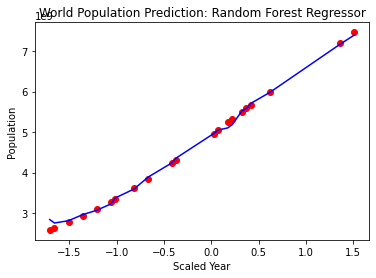

In [208]:
plt.scatter(X_test['Year'], Y_test, color = 'red')
sns.lineplot(X_test['Year'],Y_pred_RFR, color = 'blue')
plt.title('World Population Prediction: Random Forest Regressor')
plt.xlabel('Scaled Year')
plt.ylabel('Population')
plt.show()

In [209]:
print('Mean Absolute Error:',mean_absolute_error(Y_test,Y_pred_RFR))
print('R2 Score:',r2_score(Y_test,Y_pred_RFR))
print('Mean Squared Error:',mean_squared_error(Y_test,Y_pred_RFR))
print('Final Score:',(r2_score(Y_test,Y_pred_RFR)*100)/(mean_squared_error(Y_test,Y_pred_RFR)+mean_absolute_error(Y_test,Y_pred_RFR)))

Mean Absolute Error: 54836079.01761898
R2 Score: 0.9967004821427558
Mean Squared Error: 6655150286804994.0
Final Score: 1.497637815792727e-14


Since, final score of Linear regression is highest among all the rest of the models, so, Linear regression model works best for the current world population prediction model.